In [1]:
# import torch
# print (torch.cuda.is_available())

In [2]:
2+3

5

In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import time
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
df1 = pd.read_csv('Dataset/DelhiDataset_named.csv')
df2 = pd.read_csv('Dataset/KolkataDataset_named.csv')
df = pd.concat([df1,df2]).sample(frac=1).reset_index()
df.dropna(inplace=True)
df.shape , df1.shape

((23765, 4), (15438, 3))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23765 entries, 0 to 23766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       23765 non-null  int64 
 1   Unnamed: 0  23765 non-null  int64 
 2   tweet       23765 non-null  object
 3   label       23765 non-null  object
dtypes: int64(2), object(2)
memory usage: 928.3+ KB


In [7]:
df1.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: label, dtype: int64

In [8]:
df2.label.value_counts()

City program                2150
Roads related congestion    1811
Vehicle breakdown           1636
Closed Avenue               1375
Others                      1103
Road blockage                254
Name: label, dtype: int64

In [9]:
df.label.value_counts()

Traffic obstruction/car breakdown    4831
Others                               4560
Traffic congestion/heavy traffic     2821
City program                         2566
Roads related congestion             1811
Vehicle breakdown                    1636
Road closure                         1487
Closed Avenue                        1375
Water logging                        1156
Traffic information/advisory         1001
Accident                              267
Road blockage                         254
Name: label, dtype: int64

### Merging Similar Data labels as follows
Traffic obstruction/car breakdown = Vehicle breakdown

Traffic congestion/heavy traffic = Roads related congestion

Road closure = Closed Avenue

In [10]:
df.label.replace({'Traffic obstruction/car breakdown':'Vehicle breakdown','Traffic congestion/heavy traffic':'Roads related congestion','Road closure':'Closed Avenue'},inplace=True)

In [11]:
Y = df['label']
Y.value_counts()

Vehicle breakdown               6467
Roads related congestion        4632
Others                          4560
Closed Avenue                   2862
City program                    2566
Water logging                   1156
Traffic information/advisory    1001
Accident                         267
Road blockage                    254
Name: label, dtype: int64

[Text(0, 0, 'City program'),
 Text(1, 0, 'Traffic information/advisory'),
 Text(2, 0, 'Vehicle breakdown'),
 Text(3, 0, 'Closed Avenue'),
 Text(4, 0, 'Others'),
 Text(5, 0, 'Roads related congestion'),
 Text(6, 0, 'Accident'),
 Text(7, 0, 'Water logging'),
 Text(8, 0, 'Road blockage')]

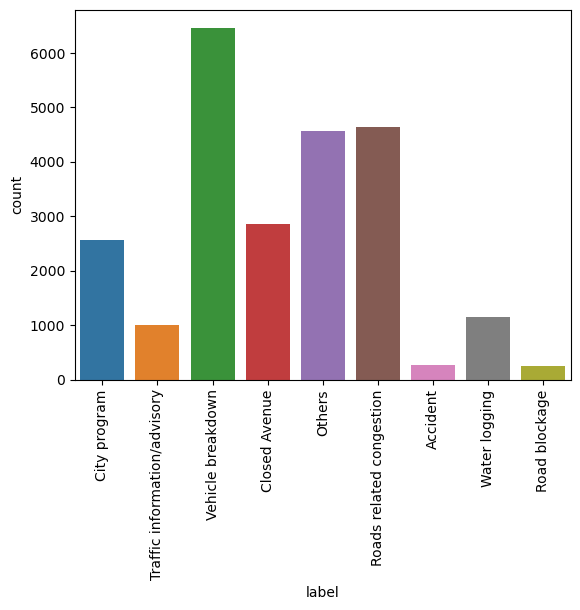

In [12]:
s = sns.countplot(x='label',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing

In [13]:
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [26]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Label :', example[1])

In [27]:
print_plot(10)
print_plot(100)

 Traffic will remain affected from Rajghat towards ISBT due to accident of an HTV Kindly avoid the stretch 
Label : Accident
due fire incident tollygunge metro station metro service suspendedmaidan kavi subhash hrs
Label : Others


In [31]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [32]:
df['tweet'] = df['tweet'].str.replace('\d+', '')

/tmp/ipykernel_323766/205990907.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet'] = df['tweet'].str.replace('\d+', '')


In [33]:
print_plot(10)
print_plot(100)

traffic remain affected rajghat towards isbt due accident htv kindly avoid stretch
Label : Accident
due fire incident tollygunge metro station metro service suspendedmaidan kavi subhash hrs
Label : Others


## Devide Data into Train Test

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['tweet'],y, stratify=df['label'])
X_train.shape, X_test.shape

((17823,), (5942,))

In [35]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [36]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    print(preprocessed_text['input_type_ids'])
    print(preprocessed_text['input_mask'])
    print(preprocessed_text['input_word_ids'])

    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    'Hello My name is Pratik'
    #'You have won a lottery! please click the link to accept it'
    ])

tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[  101  7592  2026  2171  2003 10975 10450  2243   102     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
     

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-0.8533977 , -0.48276782, -0.70477253,  0.7221814 ,  0.47630152,
        -0.1289859 ,  0.8794483 ,  0.296979  , -0.51902866, -0.99994075,
        -0.18897216,  0.842755  ,  0.9785907 ,  0.32615477,  0.9221678 ,
        -0.66120243, -0.29097137, -0.62822235,  0.34081355, -0.2721504 ,
         0.6839158 ,  0.9998238 ,  0.31350774,  0.33379447,  0.42124924,
         0.94984686, -0.756765  ,  0.9282146 ,  0.9548834 ,  0.638658  ,
        -0.61216605,  0.22108905, -0.9851122 , -0.22265477, -0.78967524,
        -0.9853174 ,  0.34586638, -0.72851366, -0.13372721,  0.05549072,
        -0.89969623,  0.3493508 ,  0.99982625, -0.493175  ,  0.3814017 ,
        -0.40842298, -0.9999994 ,  0.23310144, -0.8767494 ,  0.71798944,
         0.6924162 ,  0.5395161 ,  0.18618757,  0.4128619 ,  0.46317342,
         0.21608955, -0.07707629,  0.16406362, -0.3002871 , -0.58866423,
        -0.6664573 ,  0.4740787 , -0.69982034, -0.90390277,  0.61056167,
 

# BERT Model Configuration

In [37]:
# Bert Layers
text_input_layer = tf.keras.Input(shape=(),dtype=tf.string,name='input')
preprocessed_text_layer = bert_preprocess(text_input_layer)
encoder_layer = bert_encoder(preprocessed_text_layer)

# Neural network layers
n1 = tf.keras.layers.Dense(128, activation='ReLU', name="Dense1")(encoder_layer['pooled_output'])
n2 = tf.keras.layers.Dropout(0.1,name = 'DropOut')(n1)
output = tf.keras.layers.Dense(len(lb.classes_), activation='softmax', name="Output")(n2)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input_layer], outputs = [output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

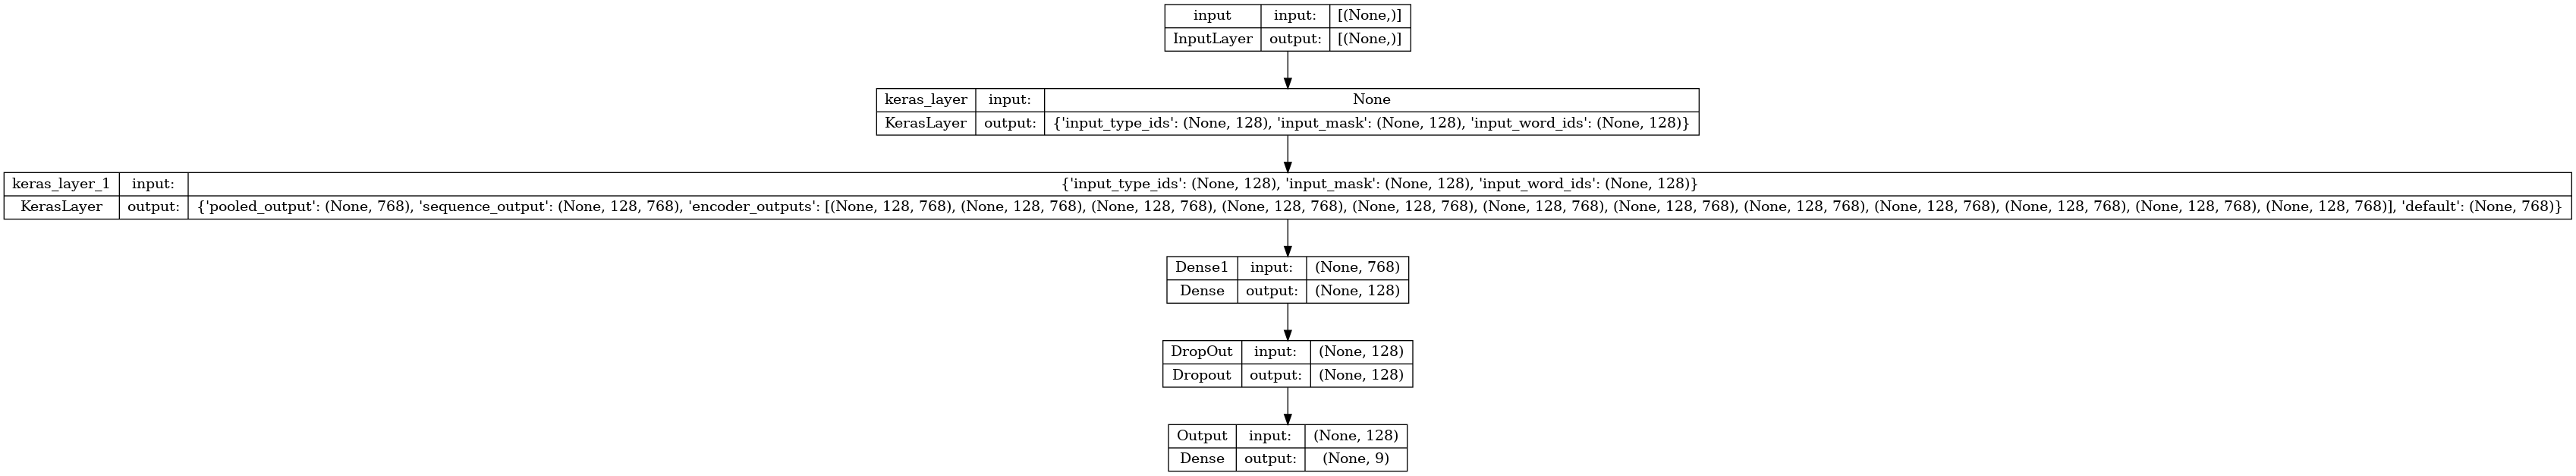

In [20]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='BERT.png', show_shapes=True)

In [38]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training

In [39]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
st = time.time()
epochs = 5
batch_size = 32

checkpoint_path = '/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-MergedCleaned/cp-{epoch:03d}-{accuracy:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = min,
    save_best_only = True,
    verbose=1)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/Bert-MergedCleaned_model.h5')

import pickle
with open('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/Bert-MergedCleaned_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)

Epoch 1/5
502/502 [==============================] - ETA: 0s - loss: 1.5712 - accuracy: 0.4364
Epoch 1: loss improved from inf to 1.57119, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-MergedCleaned/cp-001-0.4364.hdf5
502/502 [==============================] - 1284s 3s/step - loss: 1.5712 - accuracy: 0.4364 - val_loss: 1.2818 - val_accuracy: 0.5766
Epoch 2/5
502/502 [==============================] - ETA: 0s - loss: 1.2734 - accuracy: 0.5552
Epoch 2: loss improved from 1.57119 to 1.27337, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-MergedCleaned/cp-002-0.5552.hdf5
502/502 [==============================] - 1262s 3s/step - loss: 1.2734 - accuracy: 0.5552 - val_loss: 1.2540 - val_accuracy: 0.5423
Epoch 3/5
502/502 [==============================] - ETA: 0s - loss: 1.1283 - accuracy: 0.6120
Epoch 3: loss improved from 1.27337 to 1.12833, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BERT-MergedCleaned/cp-003-

# Load Model, History and Dataset

In [ ]:
# import keras

# newmodel = tf.keras.models.load_model('Bert_Kolkata_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# # new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
# model.summary()

In [ ]:
# import pickle
# with open('Bert_Kolkata_history', "rb") as file_pi:
#     newhistory = pickle.load(file_pi)

In [ ]:
# with open('KolkataTrainTestData', 'rb') as file_pi:
#     temp = pickle.load(file_pi)
# X_train = temp[0] 
# X_test = temp[1]
# y_train = temp[2]
# y_test = temp[3]

## Perform on Test Data

In [ ]:
accr = model.evaluate(X_test,Y_test)
print("Accuracy of model on test data : " , accr[1]*100 , "%")

## Result Analysis
### Plot Training Testing Accuracy and Loss

In [ ]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [ ]:
pred_test = model.predict(X_test)

In [ ]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

### Plotting Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [ ]:
# cm = confusion_matrix(y_test, y_pred)
# # cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
# plt.title('Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)
# plt.show()

# cm = confusion_matrix(y_test, y_pred)
# cm= np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
# plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
# sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
# plt.title('Normalized Confusion Matrix', size=20)
# plt.xlabel('Predicted Labels', size=14)
# plt.ylabel('Actual Labels', size=14)
# plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

In [ ]:
print('{},{:.0f},{:.4f},{:.4f}'.format(len(history.history['loss']),elapsed_time,train_acc[-1],test_acc[-1]))

## Test on Customized Tweet

In [ ]:
lb.classes_

In [ ]:
new_complaint = ['Severe accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))